In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0")

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, unit_list, activation_list, epochs=50, batch_size=256, lmbda=0, regularize=None):
        super().__init__()
        self.unit_list = unit_list
        self.activation_list = activation_list
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbda = lmbda
        self.regularize = regularize
        self.reduction = 'mean'
        self.layers = nn.ModuleList()
        
        for input_u, output_u in zip(self.unit_list,self.unit_list[1:]):
            self.layers.append(nn.Linear(input_u, output_u))
            
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        activation_dict = {'relu':lambda x, layer: F.relu(layer(x)),
                           'sigmoid': lambda x, layer: F.sigmoid(layer(x))}
        
        for layer, activation in zip(self.layers ,self.activation_list):
            x = activation_dict[activation](x, layer)
        
        x = x.reshape(x.shape[0], 1, 28, 28)
        
        return x
    
    def additional_loss(self):
        return 0

class SimpleAutoEncoder(AutoEncoder):
    def __init__(self):
        super().__init__([784, 32, 784],['relu','sigmoid']) 
    
class SparseAutoEncoder(AutoEncoder):
    def __init__(self):
        super().__init__([784, 32, 784],['relu','sigmoid'], lmbda=10e-5, regularize = [0])
        
    def additional_loss(self):
        reg_loss = 0
        for reg in self.regularize:
            reg_loss += torch.abs(list(self.parameters())[reg]).sum()
        return self.lmbda * reg_loss
    
class DeepAutoEncoder(AutoEncoder):
    def __init__(self):
        super().__init__([784, 128, 64, 32, 64, 128, 784], 
                         ['relu','relu','relu','relu','relu','sigmoid'], 100)
    
         
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, epochs=50, batch_size=128):
        super().__init__()
        self.epochs = epochs
        self.batch_size = batch_size
        self.reduction = 'mean'
        # encode
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.mp3 = nn.MaxPool2d(2, padding=1)
        
        # decode
        self.conv4 = nn.Conv2d(8, 8, 3, padding=1)
        self.up4 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(8, 8, 3, padding=1)
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(8, 16, 3)
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(16, 1, 3, padding=1)
        
    def forward(self, x):
        x = self.mp1(F.relu(self.conv1(x)))
        x = self.mp2(F.relu(self.conv2(x)))
        x = self.mp3(F.relu(self.conv3(x)))
        
        x = self.up4(F.relu(self.conv4(x)))
        x = self.up5(F.relu(self.conv5(x)))
        x = self.up6(F.relu(self.conv6(x)))
        x = torch.sigmoid(self.conv7(x))
        return x
    
    def additional_loss(self):
        return 0
    
        
class VariationalAutoEncoder(nn.Module):
    def __init__(self, epochs=50, batch_size=128):
        super().__init__()
        self.epochs = epochs
        self.batch_size = batch_size
        self.reduction = 'sum'
        
        # encode
        self.lin1 = nn.Linear(784, 512)
        self.lin2 = nn.Linear(512, 2) # mean
        self.lin3 = nn.Linear(512, 2) # log sig
        
        # decode
        self.lin4 = nn.Linear(2, 512)
        self.lin5 = nn.Linear(512, 784)
        
    def forward(self, x):
        
        x = x.view(-1, 28 * 28)
        h = F.relu(self.lin1(x))
        z_mean = self.lin2(h)
        z_log_sig = self.lin3(h)
        
        self.z_mean = z_mean
        self.z_log_sig = z_log_sig
        
        z_sig = torch.exp(z_log_sig)
        epsilon = torch.randn_like(z_sig)
        z = epsilon.mul(z_sig).add_(z_mean)
        
        dec_h = F.relu(self.lin4(z))
        dec_mean = torch.sigmoid(self.lin5(dec_h))
        dec_mean = dec_mean.reshape(dec_mean.shape[0], 1, 28, 28)
        return dec_mean
    
    def additional_loss(self):
        kl_loss = 0.5 * torch.sum(torch.exp(self.z_log_sig) + self.z_mean**2 - 1.0 - self.z_log_sig)
        return kl_loss
    

class GaussianNoise(object):
    def __init__(self, noise_factor):
        self.noise_factor = noise_factor
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.noise_factor).clamp(0,1)


def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def load_dataset(dataset, noise_input=False):
    ts = [transforms.ToTensor()]
    if noise_input: ts.append(GaussianNoise(0.5))
    transform = transforms.Compose(ts)

    trainset = dataset(root='./data', train=True, download=True, transform=transform)
    validationset = dataset(root='./data', train=False, download=True, transform=transform)
    return trainset, validationset


            
    

In [3]:
def train(model, dataset_name, denoise=False, verbose=True):
    
    
    
    # Collect the data.
    if dataset_name == "mnist":
        trainset, testset = load_dataset(torchvision.datasets.MNIST, denoise)
    elif dataset_name == "fashion_mnist":
        trainset, testset = load_dataset(torchvision.datasets.FashionMNIST, denoise)
    else:
        print("Not a valid dataset name.")
    
    # Construct the DataLoader with correct parameters.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=model.batch_size, 
                                              shuffle=True, num_workers=2)
    validation_inputs = next(iter(torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                                   shuffle=True, num_workers=2)))[0].to(device)
    
    # initialize loss function + optimizer.
    criterion = nn.BCELoss(reduction=model.reduction)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    for epoch in range(5):  #model.epochs):
        
        for i, data in enumerate(trainloader, 0):
            
            # get inputs
            inputs = data[0].to(device)
            #print(inputs.shape)
            
            # Initialize optimizer gradients.
            optimizer.zero_grad()
            
            
            outputs = model(inputs)
            #outputs = outputs.reshape(outputs.shape[0], 1, 28, 28)
            #print(outputs.shape)
            loss = criterion(outputs, inputs)
            loss += model.additional_loss()
            
            loss.backward()
            optimizer.step()
    
        if verbose:
            validation_outputs = model(validation_inputs)
            validation_loss = criterion(validation_outputs, validation_inputs)
            validation_loss += model.additional_loss()
            if model.reduction == 'sum':
                validation_loss /= len(validation_inputs)
            print('[epoch %d] loss: %.3f' % (epoch + 1, validation_loss))
            
    if verbose:
        sample_inputs = next(iter(torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=True, num_workers=2)))[0].to(device)
        sample_outputs = model(sample_inputs)
        sample_outputs.detach()
        
        imshow(torchvision.utils.make_grid(sample_inputs).cpu())
        imshow(torchvision.utils.make_grid(sample_outputs).cpu())

[epoch 1] loss: 273.554
[epoch 2] loss: 268.559
[epoch 3] loss: 265.894
[epoch 4] loss: 264.410
[epoch 5] loss: 264.202


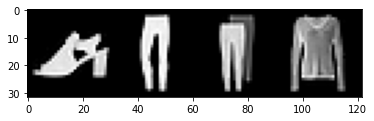

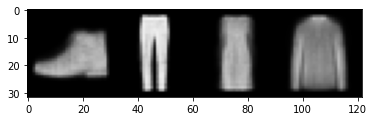

In [6]:
model = "sparse"
dataset = "mnist"
denoise = False
verbose = True 

models = {
    "simple": SimpleAutoEncoder(),
    "simple_sparse": SparseAutoEncoder(),
    "deep": DeepAutoEncoder(),
    "convolutional": ConvolutionalAutoEncoder(),
    "noisydata": ConvolutionalAutoEncoder(epochs = 100),
    "variational": VariationalAutoEncoder()
}


train(models[model].to(device), dataset, denoise=denoise, verbose = verbose)

